# Identify buildings in images

The idea is that we can combine image locations / FOV with building footprints to deduce where the buildings are in the image, and as such to link them to other metadata such as building ID. 

We assume 'infinitely tall' buildings such that we can work in 2D only. Let's start with some panoramic images and a small segment of Amsterdam buildings.

In [1]:
# # Extract small subset
# from streetscapes.streetview import SVWorkspace
# ws = SVWorkspace("amsterdam")
# metadata = ws.load_metadata('subset_lcz_kittner_081.parquet')
# sample = metadata.cx[4.900824:4.910663, 52.369162:52.372510].query('`creator.username` == "amsterdam"')[['id', 'compass_angle', 'geometry']]
# sample.to_file('municipality.gpkg', driver='GPKG')

# buildings sample is exported from QGIS, get from Bianca.

In [2]:
import geopandas as gpd

buildings = gpd.read_file('../../testsample.gpkg')
photos = gpd.read_file('../../municipality.gpkg').to_crs(buildings.crs).set_index('id')

<Axes: >

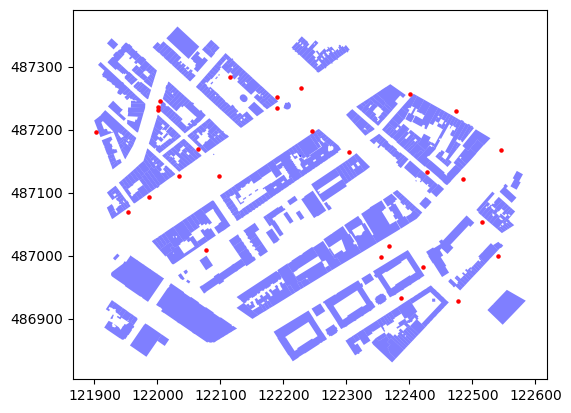

In [3]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
buildings.plot(ax=ax, color='blue', alpha=0.5)
photos.plot(ax=ax, color='red', markersize=5)

## Simplify geometry

we can use oriented envelope or minimum rotated rectangle

Or try to use unary_union to condense multipolygon into single polygon

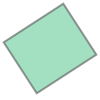

In [4]:
# Get a rectangle outline for the building
buildings.loc[538].geometry.oriented_envelope
buildings.loc[538].geometry.minimum_rotated_rectangle  # same thing

Polygon         577
MultiPolygon      3
Name: count, dtype: int64


<Axes: >

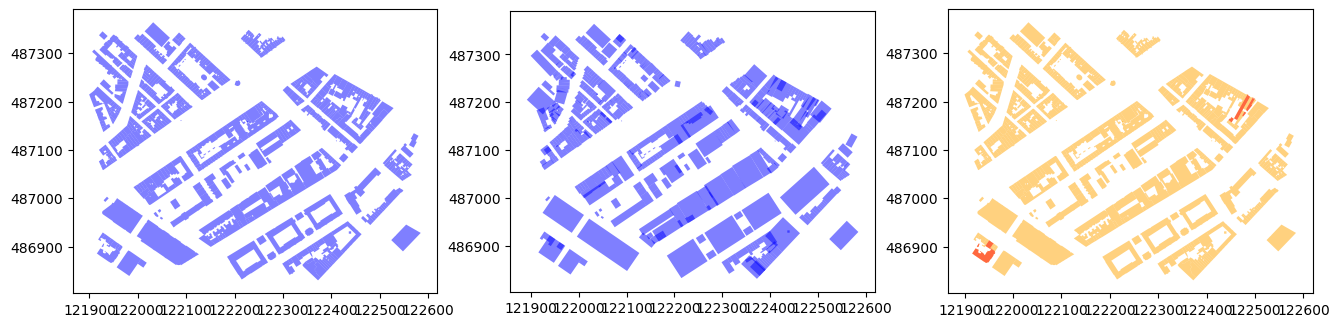

In [5]:
from shapely.ops import unary_union


fig, axs = plt.subplots(1, 3, figsize=(16, 6))

envelopes = buildings.geometry.map(lambda geom: geom.minimum_rotated_rectangle)
unioned = buildings.geometry.map(lambda geom: unary_union(geom))

# Original
buildings.plot(ax=axs[0], color='blue', alpha=0.5)

# Square envelopes
buildings.assign(geometry=envelopes).plot(ax=axs[1], color='blue', alpha=0.5)

# Simplified polygons
buildings.assign(geometry=unioned).plot(ax=axs[2], color='orange', alpha=0.5)

# Check if all multipolygons are condensed into single polygons
# Disjoint polygons can't be merged into a single polygon
print(unioned.geom_type.value_counts())
buildings.assign(geom_type = unioned.geom_type).query('geom_type == "MultiPolygon"').plot(ax=axs[2], color='red', alpha=0.5)

In [6]:
# let's continue with the simplified polygons and split the disjoint ones:
buildings = buildings.assign(geometry=unioned).explode()  # explode splits multipolygons into multiple rows with single polygons while keeping the index

## Get field of view of the images

In [7]:
def get_image_field_of_view(photos, buffer_distance=50):
    """
    Get the field of view for each photo by creating a buffer around the geometry.

    TODO: could extent this to create a wedge shape for panoramic images.
    """
    return photos.assign(geometry=photos.geometry.buffer(buffer_distance))

<Axes: >

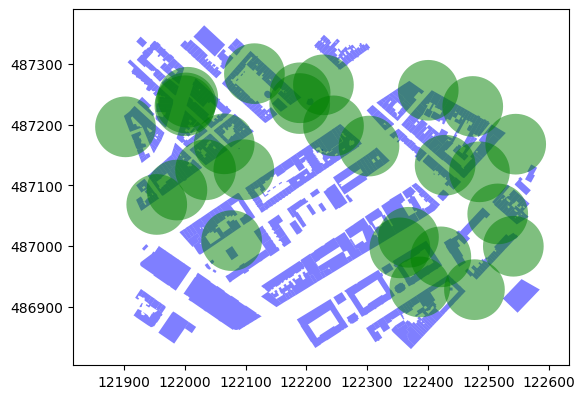

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

# All buildings and photos
buildings.plot(ax=ax, color='blue', alpha=0.5)
photos.assign(geometry = photos.geometry.buffer(50)).plot(ax=ax, color='green', alpha=0.5)

# Sort buildings by distance to the photo

In [9]:
photo = photos.loc[['1728589477321224']]
distance = buildings.geometry.map(lambda geom: geom.distance(photo.geometry).item())
buildings = buildings.assign(distance=distance).sort_values(by='distance').head(15)
buildings

,identificatie,b3_h_50p_awmean,b3_h_max,b3_h_min,b3_h_maaiveld,b3_opp_grond,b3_volume_lod22,oorspronkelijkbouwjaar,layer,path,real_b3_h_50p_awmean,building_period,HERITAGE-class,geometry,distance
564,NL.IMBAG.Pand.0363100012170566,17.073169,26.523645,3.613176,0.191,58312.500000,9.775944e+05,2000.0,ams_agg_1,C:/Users/admin_D0156526/Desktop/ams_agg_1.gpkg,16.882169,1992-2005,7,"POLYGON ((122340.508 487038, 122333.828 487049...",14.811335
565,NL.IMBAG.Pand.0363100012170563,19.165152,26.991854,8.468910,1.841,108647.000000,1.196575e+06,1998.0,ams_agg_1,C:/Users/admin_D0156526/Desktop/ams_agg_1.gpkg,17.324152,1992-2005,7,"POLYGON ((122369.242 486933.563, 122363.227 48...",20.004438
562,NL.IMBAG.Pand.0363100012165617,16.790738,26.239664,3.556516,1.456,20147.820068,2.568368e+05,2000.0,ams_agg_1,C:/Users/admin_D0156526/Desktop/ams_agg_1.gpkg,15.334738,1992-2005,7,"POLYGON ((122304.664 487036.032, 122296.414 48...",20.489985
156,NL.IMBAG.Pand.0363100012248781,14.221854,25.591179,4.841933,0.154,6915.329956,9.601889e+04,2020.0,ams_agg_1,C:/Users/admin_D0156526/Desktop/ams_agg_1.gpkg,14.067854,>=2015,9,"POLYGON ((122385.266 487045, 122379.258 487054...",33.633536
155,NL.IMBAG.Pand.0363100012246221,19.084473,26.694761,5.866517,1.015,28240.380615,5.088069e+05,2017.0,ams_agg_1,C:/Users/admin_D0156526/Desktop/ams_agg_1.gpkg,18.069473,>=2015,9,"POLYGON ((122278.398 486999.719, 122281.016 48...",45.461169
438,NL.IMBAG.Pand.0363100012170564,17.898696,22.573479,5.838828,1.859,3651.199951,5.831909e+04,1932.0,ams_agg_1,C:/Users/admin_D0156526/Desktop/ams_agg_1.gpkg,16.039696,1930-1945,3,"POLYGON ((122398.922 487054.5, 122396.148 4870...",49.324202
560,NL.IMBAG.Pand.0363100012182649,20.709959,23.495943,19.486872,1.967,792.960022,1.486265e+04,1998.0,ams_agg_1,C:/Users/admin_D0156526/Desktop/ams_agg_1.gpkg,18.742959,1992-2005,7,"POLYGON ((122337.461 486972.094, 122338.273 48...",52.518312
468,NL.IMBAG.Pand.0363100012165618,16.162478,25.903763,5.640300,1.769,50713.598633,7.293834e+05,1972.0,ams_agg_1,C:/Users/admin_D0156526/Desktop/ams_agg_1.gpkg,14.393478,1965-1974,5,"POLYGON ((122451.891 486965.938, 122450.477 48...",58.771775
444,NL.IMBAG.Pand.0363100012181203,16.439458,19.329672,11.440715,1.776,387.449989,5.686804e+03,1933.0,ams_agg_1,C:/Users/admin_D0156526/Desktop/ams_agg_1.gpkg,14.663458,1930-1945,3,"POLYGON ((122394.961 487075.188, 122396.07 487...",64.638732
439,NL.IMBAG.Pand.0363100012181204,18.000788,21.368372,14.616891,1.884,242.759995,3.928527e+03,1932.0,ams_agg_1,C:/Users/admin_D0156526/Desktop/ams_agg_1.gpkg,16.116788,1930-1945,3,"POLYGON ((122401.633 487072.344, 122400.156 48...",65.958031


### Select a few buildings and one image + get intersection

but keep as geodataframe

<Axes: >

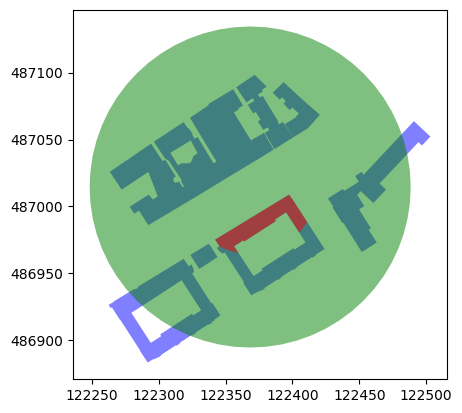

In [10]:
# Selected buildings and photo
# buildings = buildings.loc[[565, 562, 564, 560]]
fov = photo.geometry.buffer(120)

fig, ax = plt.subplots()
buildings.plot(ax=ax, color='blue', alpha=0.5)
fov.plot(ax=ax, color='green', alpha=0.5)

intersection = buildings.loc[565].geometry.intersection(photo.geometry.buffer(50))
intersection.plot(ax=ax, color='red', alpha=0.5)

## Try 'radial sweep' algorithm the get visibility 

Notice that this doesn't properly account for occlusion: the full edge is highlighted if even a small segment of it is 'hit' by a ray. The version below does a better job:

/scratch-local/69026/ipykernel_1084033/3571627041.py:157: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cam = Point(photo.geometry.x[0], photo.geometry.y[0])
/scratch-local/69026/ipykernel_1084033/3571627041.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab20")


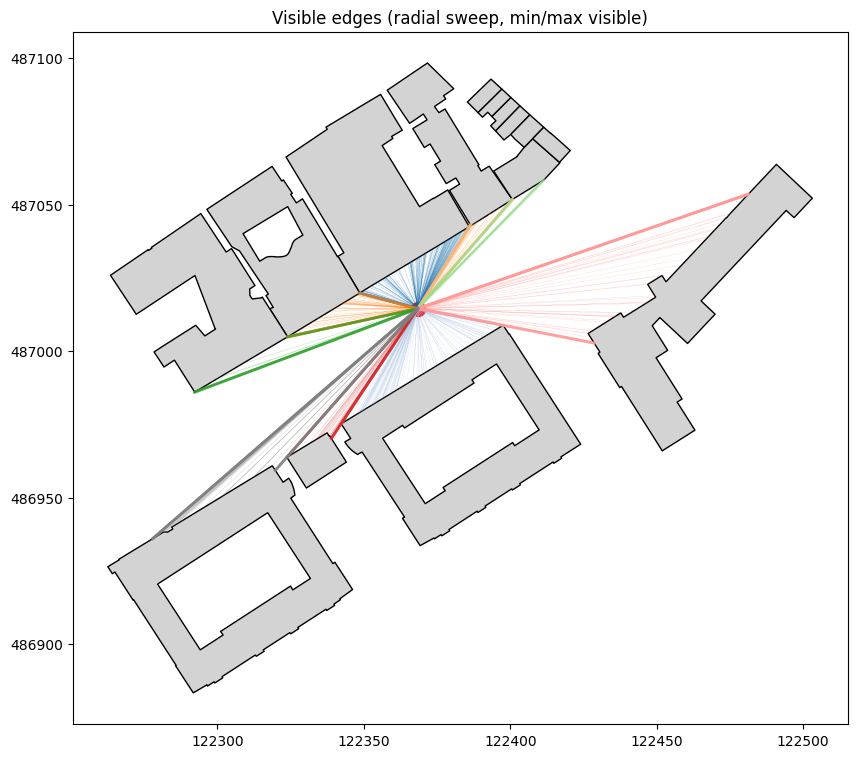

    building_idx                   identificatie  min_angle_deg  max_angle_deg
0              0  NL.IMBAG.Pand.0363100012170566      57.819200     165.023698
1              1  NL.IMBAG.Pand.0363100012170563     236.377149     348.932786
2              2  NL.IMBAG.Pand.0363100012165617     165.023699     192.245671
3              3  NL.IMBAG.Pand.0363100012248781      49.078477      57.819200
4              4  NL.IMBAG.Pand.0363100012246221     192.245671     200.531560
5              5  NL.IMBAG.Pand.0363100012170564      45.522110      49.078476
6              6  NL.IMBAG.Pand.0363100012182649     228.636448     236.377149
7              7  NL.IMBAG.Pand.0363100012165618     348.932786      19.084437
8              8  NL.IMBAG.Pand.0363100012181203            NaN            NaN
9              9  NL.IMBAG.Pand.0363100012181204            NaN            NaN
10            10  NL.IMBAG.Pand.0363100012181206            NaN            NaN
11            11  NL.IMBAG.Pand.0363100012181207    

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from matplotlib.cm import get_cmap
from matplotlib.colors import to_rgba
import pandas as pd


# --- Geometry prep helpers ---

def prepare_building_edges(buildings):
    """Extract edges from building polygons and track which building they belong to."""
    edges, edge_to_building = [], []
    building_polygons = list(buildings.geometry)
    for b_idx, poly in enumerate(building_polygons):
        coords = list(poly.exterior.coords)
        for i in range(len(coords) - 1):
            seg = LineString([coords[i], coords[i+1]])
            edges.append(seg)
            edge_to_building.append(b_idx)
    return edges, edge_to_building, building_polygons


def compute_candidate_angles(edges, cam):
    """Collect all vertex angles relative to camera and return sorted unique angles (normalized 0..2π)."""
    vertices = [pt for seg in edges for pt in seg.coords]
    angles = np.arctan2(
        np.array([y - cam.y for x, y in vertices]),
        np.array([x - cam.x for x, y in vertices])
    )
    angles = np.unique(np.concatenate([angles - 1e-8, angles, angles + 1e-8]))
    return np.mod(angles, 2 * np.pi)


def ray_line_intersect(p0, p1, ray_origin, ray_dir):
    """Return intersection of ray and segment if it exists, otherwise None."""
    x1, y1 = p0
    x2, y2 = p1
    x3, y3 = ray_origin
    dx, dy = ray_dir
    det = (x2 - x1)*(-dy) - (y2 - y1)*(-dx)
    if abs(det) < 1e-8:
        return None
    t = ((x3 - x1)*(-dy) - (y3 - y1)*(-dx))/det
    u = -((x2 - x1)*(y1 - y3) - (y2 - y1)*(x1 - x3))/det
    if 0 <= t <= 1 and u >= 0:
        return (x1 + t*(x2 - x1), y1 + t*(y2 - y1))
    return None


# --- Visibility computation ---

def initialize_building_data(num_buildings):
    """Initialize storage dict for rays and min/max angles per building."""
    return {b_idx: {"rays": [], "min_angle": None, "max_angle": None}
            for b_idx in range(num_buildings)}

def sweep_rays(angles, edges, edge_to_building, cam, max_range=80, fov=360):
    """Sweep through angles and find nearest hit per angle.
       Handles wrap-around properly for panoramic FOVs.
    """
    building_data = {
        b_idx: {"rays": [], "min_angle": None, "max_angle": None, "ref_angle": None}
        for b_idx in set(edge_to_building)
    }

    # Collect intersections
    for angle in angles:
        ray_dir = (np.cos(angle), np.sin(angle))
        min_dist2 = max_range**2
        nearest_pt = None
        nearest_building = None

        for edge, b_idx in zip(edges, edge_to_building):
            pt = ray_line_intersect(edge.coords[0], edge.coords[1], (cam.x, cam.y), ray_dir)
            if pt:
                dx = pt[0] - cam.x
                dy = pt[1] - cam.y
                dist2 = dx*dx + dy*dy
                if dist2 < min_dist2:
                    min_dist2 = dist2
                    nearest_pt = pt
                    nearest_building = b_idx

        if nearest_building is not None:
            data = building_data[nearest_building]
            data["rays"].append((angle, nearest_pt))

    # Compute min/max with wrap-around correction
    for b_idx, data in building_data.items():
        if not data["rays"]:
            continue

        # Choose reference angle (midpoint of rays OR centroid of building)
        ray_angles = np.array([a for a, _ in data["rays"]])
        # Use mean angle on the unit circle
        x = np.mean(np.cos(ray_angles))
        y = np.mean(np.sin(ray_angles))
        ref_angle = np.arctan2(y, x) % (2*np.pi)
        data["ref_angle"] = ref_angle

        if fov >= 180:  # panoramic case → unwrap around ref_angle
            rel_angles = (ray_angles - ref_angle + np.pi) % (2*np.pi) - np.pi
            min_rel, max_rel = rel_angles.min(), rel_angles.max()
            data["min_angle"] = (ref_angle + min_rel) % (2*np.pi)
            data["max_angle"] = (ref_angle + max_rel) % (2*np.pi)
        else:  # no wrap-around issue
            data["min_angle"] = ray_angles.min()
            data["max_angle"] = ray_angles.max()

    return building_data


# --- Visualization ---

def plot_rays(buildings, photo, cam, building_data):
    """Visualize buildings, rays, and highlight min/max rays."""
    fig, ax = plt.subplots(figsize=(10, 10))
    buildings.plot(ax=ax, color='lightgray', edgecolor='black')

    cmap = get_cmap("tab20")
    for b_idx, data in building_data.items():
        if not data["rays"]:
            continue
        color = to_rgba(cmap(b_idx % 20), alpha=0.7)
        # all rays lightly
        for a, pt in data["rays"]:
            ax.plot([cam.x, pt[0]], [cam.y, pt[1]], color=color, linewidth=0.05)
        # highlight min/max rays
        for a, pt in data["rays"]:
            if np.isclose(a, data["min_angle"]) or np.isclose(a, data["max_angle"]):
                ax.plot([cam.x, pt[0]], [cam.y, pt[1]], color=color, linewidth=2)

    photo.plot(ax=ax, color='red', marker='o', markersize=100)
    ax.set_title("Visible edges (radial sweep, min/max visible)")
    plt.show()


# --- Results table ---

def build_angle_table(buildings, building_data):
    """Create DataFrame with min/max angle per building in degrees."""
    angle_table = []
    for b_idx, data in building_data.items():
        angle_table.append({
            "building_idx": b_idx,
            "identificatie": buildings.iloc[b_idx]['identificatie'],
            "min_angle_deg": np.degrees(data["min_angle"]) if data["min_angle"] is not None else None,
            "max_angle_deg": np.degrees(data["max_angle"]) if data["max_angle"] is not None else None
        })
    return pd.DataFrame(angle_table)


# --- Main pipeline ---

def compute_visible_building_angles(buildings, photo, max_range=80, fov=360):
    cam = Point(photo.geometry.x[0], photo.geometry.y[0])
    edges, edge_to_building, building_polygons = prepare_building_edges(buildings)
    angles = compute_candidate_angles(edges, cam)
    building_data = initialize_building_data(len(building_polygons))
    building_data = sweep_rays(angles, edges, edge_to_building, cam, max_range, fov)
    plot_rays(buildings, photo, cam, building_data)
    angle_df = build_angle_table(buildings, building_data)
    print(angle_df)
    return angle_df, building_data

angle_df, building_data = compute_visible_building_angles(buildings, photo, max_range=120)


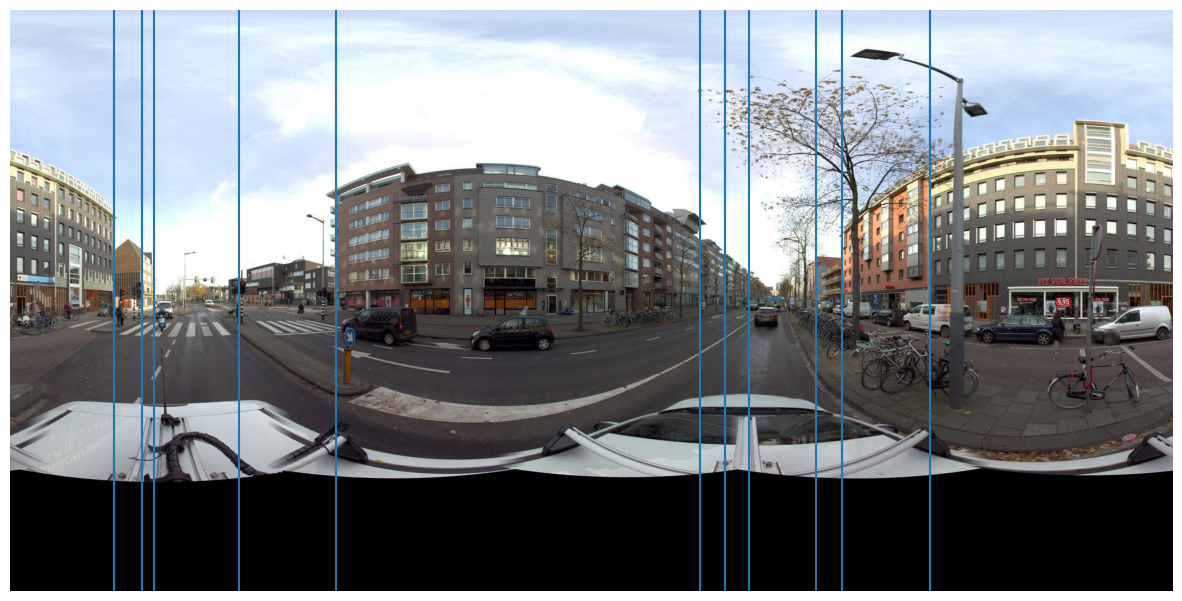

In [12]:
from PIL import Image
from streetscapes.streetview.workspace import get_image_dir
imdir = get_image_dir('mapillary')
image = Image.open(imdir / f"{photo.index[0]}.jpeg")

image_array = np.array(image)
image_array.shape

# We want 0 degrees to be the first pixel, currently 'compass_angle = 0' means
# it is exactly in the middle, so roll it back.
image_rolled = np.roll(image_array, -1024, axis=1)


def angle_to_pixel(angle, image_width=2048):
    return int(image_width / 360 * angle)

def compass_angle(angle_deg):
    compass_deg = (90 - angle_deg) % 360
    return compass_deg

fig, ax =  plt.subplots(figsize=(15, 15))
ax.imshow(image_rolled)
plt.axis('off')

for i, building in angle_df.dropna().iterrows():
    plt.axvline(angle_to_pixel(compass_angle(building.min_angle_deg)))
    plt.axvline(angle_to_pixel(compass_angle(building.max_angle_deg)))

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.cm import get_cmap
from matplotlib.colors import to_rgba

# --- helpers (same logic you used before) ---

def _mathdeg_to_compass_deg(angle_deg):
    # math: 0=East, CCW  →  compass: 0=North, CW
    return (90.0 - angle_deg) % 360.0

def _deg_to_pixel(deg, width):
    return int((deg % 360.0) / 360.0 * width)

def _roll_north_to_left(image_array):
    # Your panoramas have 0° (North) in the middle → roll left by W/2
    w = image_array.shape[1]
    return np.roll(image_array, -w // 2, axis=1)

def plot_building_angles_fill(image_array, angle_df, figsize=(15, 5), alpha_fill=0.3):
    """
    Show the panorama with per-building angle spans overlaid as colored bands.
    - angle_df must have columns: 'min_angle_deg', 'max_angle_deg', 'identificatie' (optional).
    - min/max are in *math degrees* (like your original np.degrees output).
    """
    rolled = _roll_north_to_left(image_array)
    w = rolled.shape[1]
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(rolled)
    ax.axis("off")

    cmap = get_cmap("tab20")

    for i, row in angle_df.iterrows():
        mind = row.get("min_angle_deg", None)
        maxd = row.get("max_angle_deg", None)
        if pd.isna(mind) or pd.isna(maxd):
            continue

        # math → compass → pixels
        dmin = _mathdeg_to_compass_deg(mind)
        dmax = _mathdeg_to_compass_deg(maxd)
        p1 = _deg_to_pixel(dmin, w)
        p2 = _deg_to_pixel(dmax, w)

        color = to_rgba(cmap(i % 20), alpha=alpha_fill)

        # Fill the *shorter arc* on the circle
        delta = (p2 - p1) % w
        if delta == 0:
            ax.axvline(p1, color=color, linewidth=2)
        elif delta <= w // 2:
            if p1 <= p2:
                ax.axvspan(p1, p2, color=color)
            else:
                ax.axvspan(p1, w, color=color)
                ax.axvspan(0, p2, color=color)
        else:
            if p2 <= p1:
                ax.axvspan(p2, p1, color=color)
            else:
                ax.axvspan(p2, w, color=color)
                ax.axvspan(0, p1, color=color)

    ax.set_title("Building angle spans (rolled: 0° compass at left)")
    plt.show()

/scratch-local/69026/ipykernel_1084033/3445680352.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab20")


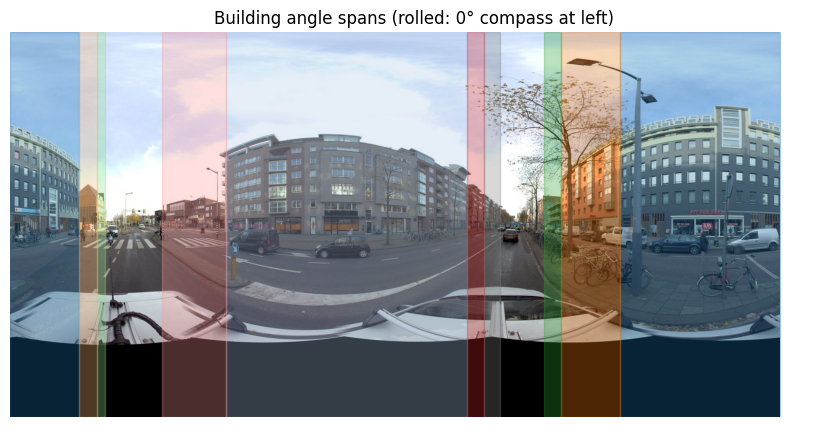

In [14]:
plot_building_angles_fill(image_array, angle_df, figsize=(15, 5), alpha_fill=0.3)


In [15]:
def _crop_shorter_arc(rolled, p1, p2):
    """
    Crop the *shorter* arc of columns between p1 and p2 on the rolled panorama.
    Handles wrap-around. Returns cropped image (H x Wc x C).
    """
    H, W, C = rolled.shape
    p1 %= W
    p2 %= W
    delta = (p2 - p1) % W  # width going p1 -> p2

    if delta == 0:
        return None  # degenerate (no visible span)

    if delta <= W // 2:
        # take arc p1 -> p2
        if p1 <= p2:
            return rolled[:, p1:p2, :]
        else:
            return np.hstack([rolled[:, p1:, :], rolled[:, :p2, :]])
    else:
        # take arc p2 -> p1 (the other, shorter side)
        if p2 <= p1:
            return rolled[:, p2:p1, :]
        else:
            return np.hstack([rolled[:, p2:, :], rolled[:, :p1, :]])


def plot_building_crops_variable_width(image_array, angle_df, figsize=(20, 5)):
    rolled = _roll_north_to_left(image_array)
    W = rolled.shape[1]

    crops, titles, widths = [], [], []
    for _, row in angle_df.iterrows():
        mind, maxd = row.get("min_angle_deg"), row.get("max_angle_deg")
        if pd.isna(mind) or pd.isna(maxd):
            continue
        dmin = _mathdeg_to_compass_deg(mind)
        dmax = _mathdeg_to_compass_deg(maxd)
        p1, p2 = _deg_to_pixel(dmin, W), _deg_to_pixel(dmax, W)
        crop = _crop_shorter_arc(rolled, p1, p2)
        if crop is None or crop.shape[1] == 0:
            continue
        crops.append(crop)
        titles.append(str(row.get("identificatie", row.get("building_idx"))))
        widths.append(crop.shape[1])

    if not crops:
        print("No valid building crops to show.")
        return

    # --- sort by width ---
    sorted_items = sorted(zip(widths, crops, titles), key=lambda x: x[0], reverse=True)
    widths, crops, titles = zip(*sorted_items)

    # --- layout with width ratios ---
    total_w = sum(widths)
    width_ratios = [w / total_w for w in widths]

    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(1, len(crops), width_ratios=width_ratios)

    for i, (crop, title) in enumerate(zip(crops, titles)):
        ax = fig.add_subplot(gs[0, i])
        ax.imshow(crop, aspect="auto")
        ax.set_title(title, fontsize=8)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


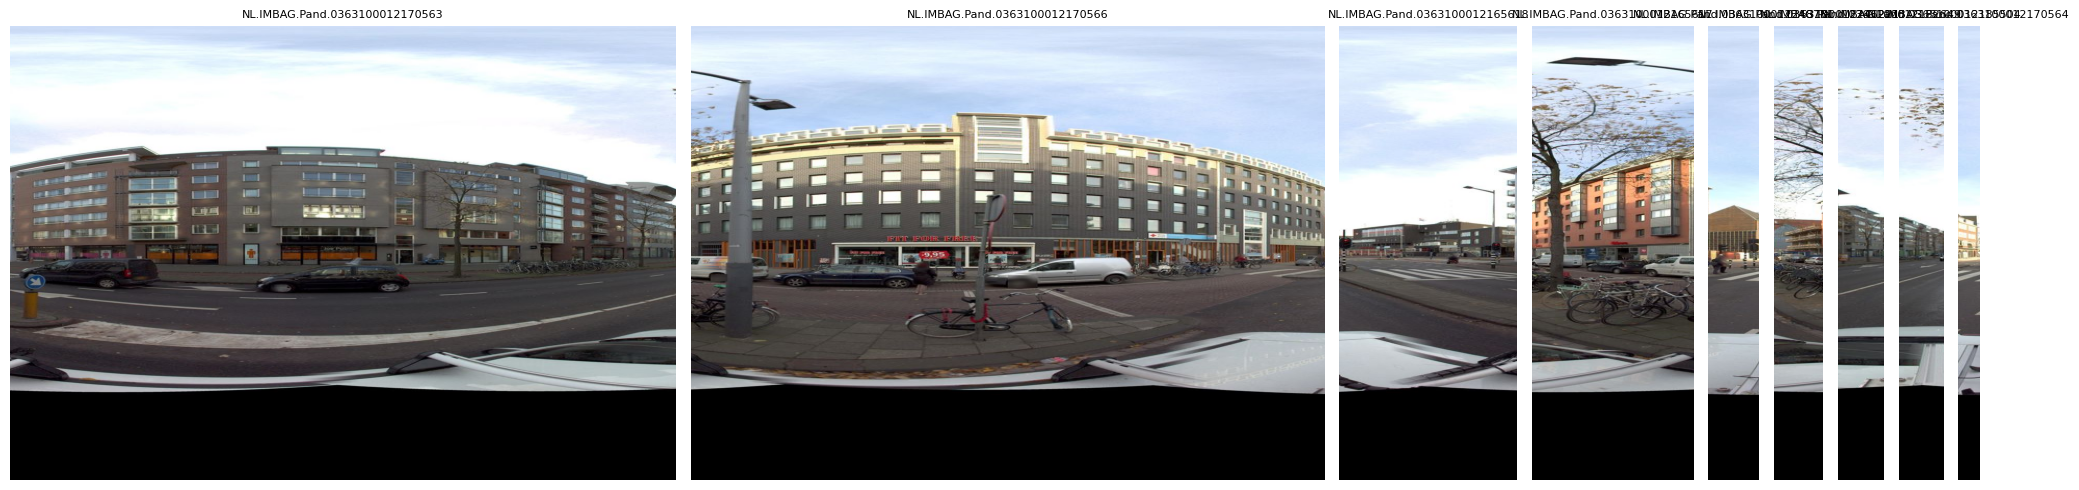

In [16]:
plot_building_crops_variable_width(image_array, angle_df)